# Extracción y Selección de Características
# Ejemplos Varios<a class="tocSkip">
## Minería de Datos y Patrones <a class="tocSkip">
### Ingenieria Electrónica <a class="tocSkip">
### Universidad Popular del Cesar <a class="tocSkip">
### Prof.: Jose Ramón Iglesias Gamarra - [https://github.com/joseramoniglesias/](https://github.com/joseramoniglesias/) <a class="tocSkip">
  **joseiglesias@unicesar.edu.co**

---

# Ejemplo: Extracción y Selección de Caracteristicas Geométricas

En este ejemplo se muestra cómo extraer y seleccionar características geométricas para separar 5 caracteres (A,B,X,Y,Z).




# Setup inicial

Liberías necesarias para que funcione el algoritmo.

## Setup de librerías

In [1]:
import numpy as np
import cv2
import skimage
import warnings
import matplotlib.pyplot as plt
from   sklearn.metrics import confusion_matrix, accuracy_score
from   seaborn import heatmap
from   tqdm.auto import tqdm
from   sklearn.neighbors import KNeighborsClassifier
from   skimage.segmentation import find_boundaries
from   scipy.ndimage.morphology import binary_fill_holes
from   skimage.morphology import disk,dilation


C:\Users\joser\AppData\Local\Temp\ipykernel_7064\1279541239.py:11: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from   scipy.ndimage.morphology import binary_fill_holes


# Ejemplo: Reconocimiento de 5 caracteres

En este ejemplo se realiza la extracción de características necesarias para realizar un reconocimiento de los caracteres A,B,X,Y,Z con diversos tamaños y diversas orientaciones. 


Para la solución se utiliza los descriptores ya que son invariantes a la rotación y a la escala. 




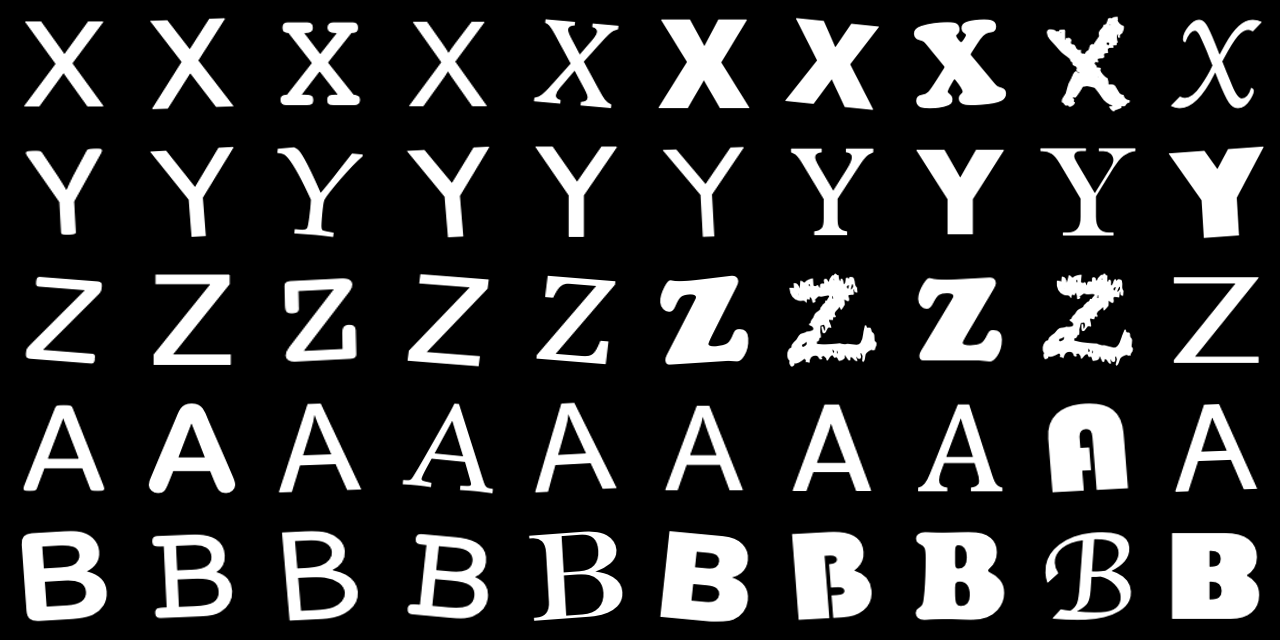

# Carga de base de datos

La base de datos consiste en 5 clases y 100 imágenes por clase

In [1]:
# Carga de base de datos
!wget https://www.dropbox.com/s/18poez6tafn01pe/ABXYZ.zip?dl=0
!unzip ABXYZ.zip

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


# Funciones necesarias

In [2]:
def basicgeo(R,names=False):
  # center of mass
  ij = np.argwhere(R)
  ii = ij[:,0]
  jj = ij[:,1]
  i_m = np.mean(ii)
  j_m = np.mean(jj)

  # height
  h = np.max(ii)-np.min(ii)+1

  # width
  w = np.max(jj)-np.min(jj)+1

  # area
  area = np.sum(R)

  # perimeter
  # https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.find_boundaries
  B = skimage.segmentation.find_boundaries(R,mode='inner')
  perimeter = np.sum(B)


  # regionprops
  # https://scikit-image.org/docs/stable/api/skimage.measure.html#regionprops
  props        = skimage.measure.regionprops(R)[0]

  #perimeter    = props.perimeter
  roundness    = 4*area*np.pi/perimeter/perimeter
  solidity     = props.solidity
  euler_number = props.euler_number
  eq_diameter  = props.equivalent_diameter_area
  axis_major   = props.axis_major_length
  axis_minor   = props.axis_minor_length
  orientation  = props.orientation
  extent       = props.extent
  eccentricity = props.eccentricity
  area_convex  = props.area_convex

  # roundness
  #roundness    = 4*area*np.pi/perimeter/perimeter

  X = [i_m,j_m,h,w,area,perimeter,roundness,
       euler_number,eq_diameter,axis_major,axis_minor,
       orientation,solidity,extent,
       eccentricity,area_convex]
  if names:
    Xn = ['i_m','j_m','height','width','area','perimeter','roundness',
          'euler_number','equivalent_diameter','major_axis','minor_axis',
          'orientation','solidity','extent',
          'eccentricity','convex_area_convex']
    return X,Xn
  else:
    return X

def minmax(X):
  ma = X.max(0)
  mi = X.min(0)
  md    = ma-mi
  a     = 1/ md
  b     = -mi/md
  return X * a + b, a, b

def num2fixstr(x,d):
  st = '%0*d' % (d,x)
  return st

def imageload(prefix,num_class,digits_class,num_img,digits_img,sep='_',echo='off'):
  st   = prefix + num2fixstr(num_class,digits_class) + sep + num2fixstr(num_img,digits_img) + '.png'
  if echo == 'on':
    print('loading image '+st+'...')
  img    = plt.imread(st)
  return img


# Separación entre training y testing
# Separación entre training y testing
def SplitTrainTest(X,y,n):

  K      = np.max(y)+1              # número de clases
  N      = int(X.shape[0]/K)        # numeros de muestras por clase
  Ntrain = n*K                      # número de muestras para el training
  Ntest  = K*N-Ntrain               # número de muestras para el testing
  M      = X.shape[1]               # número de características por muestra
  Xtrain = np.zeros((Ntrain,M))     # subset de training
  ytrain = np.zeros((Ntrain),'int') # ground truth del training         
  Xtest  = np.zeros((Ntest,M))      # subset de testing
  ytest  = np.zeros((Ntest),'int')  # ground truth del testing  

  # contadores
  itrain = 0
  itest  = 0
  t      = 0

  for j in range(K):     # para cada clase
    for i in range(N):   # para cada imagen de la clase
      if i<n: # training
        Xtrain[itrain,:] = X[t,:]
        ytrain[itrain] = y[t]
        itrain = itrain+1
      else:  # testing
        Xtest[itest,:] = X[t,:]
        ytest[itest] = y[t]
        itest = itest+1
      t = t+1

  return Xtrain,ytrain,Xtest,ytest

# Clasificación usando KNN
def ClassifierKNN(Xtrain,ytrain,Xtest,ytest,n_neighbors=1,normalize=True,echo=True):
  if normalize:
    Xtrain, a, b = minmax(Xtrain)
    Xtest        = Xtest * a + b
  knn = KNeighborsClassifier(n_neighbors=n_neighbors)
  knn.fit(Xtrain, ytrain)
  ypred        = knn.predict(Xtest)
  acc          = accuracy_score(ytest,ypred)
  C = confusion_matrix(ytest,ypred)
  if echo:
    print('Training with '+str(Xtrain.shape[0])+' samples. Testing with '+str(Xtest.shape[0])+' samples (of '+str(Xtrain.shape[1])+ ' features)...')
    print('Testing Accuracy = '+str(acc*100)+'%')
    print('Confusion Matrix:')
    print(C)
  return acc,C

def score(features, ypred, *, method='fisher', param=None):
  if param is None:
    dn = ypred.max() - ypred.min() + 1  # number of classes
    p = np.ones((dn, 1)) / dn
  else:
    p = param

  if method == 'mi':  # mutual information
    raise NotImplementedError()

  # maximal relevance
  elif method == 'mr':
    raise NotImplementedError()

  # minimal redundancy and maximal relevance
  elif method == 'mrmr':
    raise NotImplementedError()

  # fisher
  elif method == 'fisher':
    return jfisher(features, ypred, p)

  elif method == 'sp100':
    return sp100(features, ypred)

  else:
    return 0

def clean(features, show=False):
  n_features = features.shape[1]
  ip = np.ones(n_features, dtype=int)

  # cleaning correlated features
  warnings.filterwarnings('ignore')
  C = np.abs(np.corrcoef(features, rowvar=False))
  idxs = np.vstack(np.where(C > .99))

  # remove pairs of same feature ( feature i will have a correlation of 1 whit itself )
  idxs = idxs[:, idxs[0,:] != idxs[1,:]]

  # remove correlated features
  if idxs.size > 0:
    ip[np.max(idxs, 0)] = 0

  # remove constant features
  s = features.std(axis=0, ddof=1)
  ip[s < 1e-8] = 0
  p = np.where(ip.astype(bool))[0]

  if show:
    print(f'Clean: number of features reduced from {n_features} to {p.size}.')

  return p

def jfisher(features, ypred, p=None):
  m = features.shape[1]

  norm = ypred.ravel() - ypred.min()
  max_class = norm.max() + 1

  if p is None:
    p = np.ones(shape=(max_class, 1)) / max_class

  # Centroid of all samples
  features_mean = features.mean(0)

  # covariance within class 
  cov_w = np.zeros(shape=(m, m))

  # covariance between classes
  cov_b = np.zeros(shape=(m, m))

  for k in range(max_class):
    ii = (norm == k)                                   # indices from class k
    class_features = features[ii,:]                    # samples of class k
    class_mean = class_features.mean(0)                # centroid of class k 
    class_cov = np.cov(class_features, rowvar=False)   # covariance of class k

    cov_w += p[k] * class_cov                          # within-class covariance

    dif = (class_mean - features_mean).reshape((m, 1))
    cov_b += p[k] * dif @ dif.T                        # between-class covariance
  try:
    return np.trace(np.linalg.inv(cov_w) @ cov_b)
  except np.linalg.LinAlgError:
    return - np.inf

def normalize(X):
  mf = X.mean(0)
  sf = X.std(0)
  a = 1 / sf
  b = - mf / sf
  return X * a + b, a, b

def sfs(features, ypred, n_features, *, force=False, method='fisher', options=None, show=False):

  N, M = features.shape
  remaining_feats = set(np.arange(M))
  selected = list()
  curr_feats = np.zeros((N, 0))
  if options is None:
    options = dict()

  def _calc_score(i):
    feats = np.hstack([curr_feats, features[:, i].reshape(-1, 1)])
    return score(feats, ypred, method=method, **options)

  if show:
    _range = tqdm.trange(
      n_features, desc='Selecting Features', unit_scale=True, unit=' features')
  else:
    _range = range(n_features)

  for _ in _range:
    new_selected = max(remaining_feats, key=_calc_score)
    selected.append(new_selected)
    remaining_feats.remove(new_selected)
    curr_feats = np.hstack(
      [curr_feats, features[:, new_selected].reshape(-1, 1)])

  return np.array(selected)

def choose(n, k):
  return int(np.math.factorial(n) / (np.math.factorial(n - k) * np.math.factorial(k)))

def exsearch(features, ypred, n_features, *, method='fisher', options=None, show=False):
  if options is None:
    options = dict()

  tot_feats = features.shape[1]
  N = choose(tot_feats, n_features)

  if N > 10000:
    warnings.warn(
      f'Doing more than 10.000 iterations ({N}). This may take a while...')

  def _calc_score(ii):
    feats = features[:, ii]
    return score(feats, ypred, method=method, **options)

  _combinations = combinations(range(tot_feats), n_features)

  if show:
    _combinations = zip(tqdm.trange(N,
                                    desc='Combinations checked',
                                    unit_scale=True,
                                    unit=' combinations'),
                        _combinations)

    _combinations = (ii for _, ii in _combinations)

  chosen_feats = max(_combinations, key=_calc_score)

  return np.array(chosen_feats)

def hugeo(R,names=False):
  # regionprops
  # https://scikit-image.org/docs/stable/api/skimage.measure.html#regionprops
  props = skimage.measure.regionprops(R)[0]

  X = props.moments_hu

  if names:
    Xn = ['Hu-moment-1','Hu-moment-2','Hu-moment-3','Hu-moment-4','Hu-moment-5','Hu-moment-6','Hu-moment-7']
    return X,Xn
  else:
    return X

def flusser(R,names=False):
  moments = cv2.moments(R, True)
  u00,u20, u11, u02, u30, u21, u12, u03 = moments['m00'], moments['mu20'], moments['mu11'], moments['mu02'], moments['mu30'], moments['mu21'], moments['mu12'], moments['mu03']
  I1 = (u20*u02-u11**2)/u00**4 ;
  I2 = (u30**2*u03**2-6*u30*u21*u12*u03+4*u30*u12**3+4*u21**3*u03-3*u21**2*u12**2)/u00**10;
  I3 = (u20*(u21*u03-u12**2)-u11*(u30*u03-u21*u12)+u02*(u30*u12-u21**2))/u00**7;
  I4 = (u20**3*u03**2-6*u20**2*u11*u12*u03-6*u20**2*u02*u21*u03+9*u20**2*u02*u12**2 + 12*u20*u11**2*u21*u03+6*u20*u11*u02*u30*u03-18*u20*u11*u02*u21*u12-8*u11**3*u30*u03- 6*u20*u02**2*u30*u12+9*u20*u02**2*u21+12*u11**2*u02*u30*u12-6*u11*u02**2*u30*u21+u02**3*u30**2)/u00**11;
  X = [I1,I2,I3,I4]
  if names:
    Xn = ['Flusser-1','Flusser-2','Flusser-3','Flusser-4']
    return X,Xn
  else:
    return X



def efd_descriptors(contour, order=10, normalize=True):
  # From https://github.com/hbldh/pyefd

  """Calculate elliptical Fourier descriptors for a contour.
  :param numpy.ndarray contour: A contour array of size ``[M x 2]``.
  :param int order: The order of Fourier coefficients to calculate.
  :param bool normalize: If the coefficients should be normalized;
      see references for details.
  :param bool return_transformation: If the normalization parametres should be returned.
      Default is ``False``.
  :return: A ``[order x 4]`` array of Fourier coefficients and optionally the
      transformation parametres ``scale``, ``psi_1`` (rotation) and ``theta_1`` (phase)
  :rtype: ::py:class:`numpy.ndarray` or (:py:class:`numpy.ndarray`, (float, float, float))
  """
  dxy = np.diff(contour, axis=1)
  dxy = dxy.reshape(dxy.shape[1],2)
  dt = np.sqrt((dxy ** 2).sum(axis=1))
  t = np.concatenate([([0.0]), np.cumsum(dt)])
  T = t[-1]

  phi = (2 * np.pi * t) / T

  orders = np.arange(1, order + 1)
  consts = T / (2 * orders * orders * np.pi * np.pi)
  phi = phi * orders.reshape((order, -1))

  d_cos_phi = np.cos(phi[:, 1:]) - np.cos(phi[:, :-1])
  d_sin_phi = np.sin(phi[:, 1:]) - np.sin(phi[:, :-1])

  a = consts * np.sum((dxy[:, 0] / dt) * d_cos_phi, axis=1)
  b = consts * np.sum((dxy[:, 0] / dt) * d_sin_phi, axis=1)
  c = consts * np.sum((dxy[:, 1] / dt) * d_cos_phi, axis=1)
  d = consts * np.sum((dxy[:, 1] / dt) * d_sin_phi, axis=1)

  coeffs = np.concatenate(
    [
      a.reshape((order, 1)),
      b.reshape((order, 1)),
      c.reshape((order, 1)),
      d.reshape((order, 1)),
    ],
    axis=1,
  )

  if normalize:
    theta_1 = 0.5 * np.arctan2(
      2 * ((coeffs[0, 0] * coeffs[0, 1]) + (coeffs[0, 2] * coeffs[0, 3])),
      (
              (coeffs[0, 0] ** 2)
              - (coeffs[0, 1] ** 2)
              + (coeffs[0, 2] ** 2)
              - (coeffs[0, 3] ** 2)
      ),
    )
    # Rotate all coefficients by theta_1.
    for n in range(1, coeffs.shape[0] + 1):
      coeffs[n - 1, :] = np.dot(
        np.array(
          [
            [coeffs[n - 1, 0], coeffs[n - 1, 1]],
            [coeffs[n - 1, 2], coeffs[n - 1, 3]],
          ]
        ),
        np.array(
          [
            [np.cos(n * theta_1), -np.sin(n * theta_1)],
            [np.sin(n * theta_1), np.cos(n * theta_1)],
          ]
        ),
      ).flatten()

    # Make the coefficients rotation invariant by rotating so that
    # the semi-major axis is parallel to the x-axis.
    psi_1 = np.arctan2(coeffs[0, 2], coeffs[0, 0])
    psi_rotation_matrix = np.array(
      [[np.cos(psi_1), np.sin(psi_1)], [-np.sin(psi_1), np.cos(psi_1)]]
    )
    # Rotate all coefficients by -psi_1.
    for n in range(1, coeffs.shape[0] + 1):
      coeffs[n - 1, :] = psi_rotation_matrix.dot(
        np.array(
          [
            [coeffs[n - 1, 0], coeffs[n - 1, 1]],
            [coeffs[n - 1, 2], coeffs[n - 1, 3]],
          ]
        )
      ).flatten()

    size = coeffs[0, 0]
    # Obtain size-invariance by normalizing.
    coeffs /= np.abs(size)
  X = coeffs.reshape(4*order,)

  return X

def efourierdes(R, order=10, names=False):
  # Elliptic Fourier Descriptors from https://github.com/hbldh/pyefd
  R8h    = binary_fill_holes(R).astype(np.uint8)
  contours, hierarchy = cv2.findContours(R8h, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  X = efd_descriptors(contours, order=order)

  if names==True:
    Xn = []
    for k in range(order):
      Xn.append('Fourierdes-a-'+str(k))
      Xn.append('Fourierdes-b-'+str(k))
      Xn.append('Fourierdes-c-'+str(k))
      Xn.append('Fourierdes-d-'+str(k))
    return X,Xn
  else:
    return X

from   skimage.segmentation import find_boundaries
from   scipy.ndimage import binary_fill_holes


def fourierdes(R, n_des=16, names=False):

  R8h    = binary_fill_holes(R).astype(np.uint8)
  contour, hierarchy = cv2.findContours(R8h, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  x = np.array(contour)
  B = x.reshape(x.shape[1],2)
  V = B[:, 0] + 1j * B[:, 1]
  m = B.shape[0]

  r = np.zeros(m, dtype=complex)
  phi = np.zeros(m)
  dphi = np.zeros(m)
  l = np.zeros(m)
  dl = np.zeros(m)

  r[0] = V[0] - V[m-1]
  r[1:] = V[1:] - V[:m-1]

  dl = np.abs(r)
  phi = np.angle(r)

  dphi[:m-1] = np.mod(phi[1:] - phi[:m-1] + np.pi, 2 * np.pi) - np.pi
  dphi[m-1] = np.mod(phi[0] - phi[m-1] + np.pi, 2 * np.pi) - np.pi

  l[0] = dl[0]
  for k in range(1, m):
    l[k] = l[k-1] + dl[k]

  l = l * (2 * np.pi / l[m-1])
  descriptors = np.zeros(n_des)

  for n in range(1, n_des + 1):
    an = (dphi * np.sin(l * n)).sum()
    bn = (dphi * np.cos(l * n)).sum()
    an = -an / n / np.pi
    bn = bn / n / np.pi
    imagi = an + 1j * bn
    descriptors[n-1] = np.abs(imagi)

  X = descriptors

  if names:
    return np.array([f'Fourier-des {n+1:>2d}' for n in range(n_des)]), descriptors
  return X

def fit_ellipse(x,y):
  # Fitzgibbon, A.W., Pilu, M., and Fischer R.B., 
  # Direct least squares fitting of ellipses, 1996
  x        = x[:,None]
  y        = y[:,None]
  D        = np.hstack([x*x,x*y,y*y,x,y,np.ones(x.shape)])
  S        = np.dot(D.T,D)
  C        = np.zeros([6,6])
  C[0,2]   = C[2,0] = 2
  C[1,1]   = -1
  E,V      = np.linalg.eig(np.dot(np.linalg.inv(S),C))
  n        = np.argmax(E)
  s        = V[:,n]
  a        = s[0]
  b        = s[1]/2.
  c        = s[2]
  d        = s[3]/2.
  f        = s[4]/2.
  g        = s[5]
  dd       = b*b-a*c
  cx       = (c*d-b*f)/dd
  cy       = (a*f-b*d)/dd
  alpha    = 0.5*np.arctan(2*b/(a-c))*180/np.pi
  up       = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
  down1    = (b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
  down2    = (b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
  a        = np.sqrt(abs(up/down1))
  b        = np.sqrt(abs(up/down2))
  area     = np.pi*a*b

  if b>a:
    ecc  = a/b
  else:
    ecc  = b/a

  features = [cx,cy,a,b,alpha,ecc,area]

  return features

def fitellipse(R,names=False):
  E        = find_boundaries(R, mode='outer').astype(np.uint8)
  # E        = bwperim(R)
  data     = np.argwhere(E==True)
  y        = data[:,0]
  x        = data[:,1]
  X       = fit_ellipse(x,y)
  if names:
    Xn = ['cx','cy','a','b','alpha','ecc','area']
    return X,Xn
  else:
    return X
  return features

def gupta(R, names=False):

  B = skimage.segmentation.find_boundaries(R,mode='inner')
  i_perim, j_perim = np.where(B.astype(bool))
  im_perim = i_perim + j_perim * 1j
  ix = i_perim.mean()
  jx = j_perim.mean()
  centre = ix + jx * 1j
  z = np.abs(im_perim - centre)
  m1 = z.mean()

  mur1 = z - m1
  mur2 = mur1 * mur1
  mur3 = mur1 * mur2
  mur4 = mur2 * mur2

  mu2 = mur2.mean()
  mu3 = mur3.mean()
  mu4 = mur4.mean()

  F1 = (mu2 ** .5) / m1
  F2 = mu3 / (mu2 * (mu2 ** .5))
  F3 = mu4 / mu2 ** 2

  X = np.array([F1, F2, F3])

  if names:
    Xn = ['Gupta-1','Gupta-2','Gupta-3']
    return X,Xn
  else:
    return X


# Extracción de Características Geométricas

In [90]:
K = 5   # number of classes
N = 100 # number of images per class

# Basic geometric features
Mbg  = 16
Xbg = np.zeros((K*N,Mbg))

# Fourier descriptors
Mfd  = 16
Xfd  = np.zeros((K*N,Mfd))

# Hu moments
Mhu  = 7
Xhu  = np.zeros((K*N,Mhu))

# Flusser moments
Mfl  = 4
Xfl  = np.zeros((K*N,Mfl))

# Gupta moments
Mgu  = 3
Xgu  = np.zeros((K*N,Mgu))

y    = np.zeros((K*N),'int')               # ground truth

t = 0
for j in range(K):
  for i in tqdm(range(N)):
    # Lectura de la imagen
    img      = imageload('ABXYZ/char_',j+1,2,i+1,3,echo='off')
    img3     = dilation(img,disk(3)) # join I with 3 to build a B
    R        = img3 > 0.5
    R        = binary_fill_holes(R).astype(int)

    Xfd[t,:] = fourierdes(R)
    Xhu[t,:] = hugeo(R)
    Xfl[t,:] = flusser(R)
    Xgu[t,:] = gupta(R)
    Xbg[t,:] = basicgeo(R)

    y[t] = j
    t = t+1

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# Estrategia Básica

0. Selección Manual $\rightarrow$ 

1. Definición de características Originales $\rightarrow$ 

2. Clean $\rightarrow$ 

3. Normalización $\rightarrow$ 

4. Selección con SFS $\rightarrow$

## 0) Selección Manual
Sólo deben procesarse características invariantes a la rotación y traslación, para evitar falsa correlaciones.

Características extraidas con `basicgeo`.

* $f_{0}$: Center of mass in $i$ direction. $\leftarrow$ remover

* $f_{1}$: Center of mass in $j$ direction. $\leftarrow$ remover

* $f_{2}$: Height.

* $f_{3}$: Width.

* $f_{4}$: Area.

* $f_{5}$: Perimeter.

* $f_{6}$: Roundness.

* $f_{7}$: Danielsson factor.

* $f_{8}$: Euler Number.

* $f_{9}$: Equivalent Diameter.

* $f_{10}$: Major Axis Length.

* $f_{11}$: Minor Axis Length.

* $f_{12}$: Orientation. $\leftarrow$ remover

* $f_{13}$: Solidity.

* $f_{14}$: Extent.

* $f_{15}$: Eccentricity.

* $f_{16}$: Convex Area.

* $f_{17}$: Filled Area.

Es necesario eliminar aquellas que son variantes a la traslación y rotación. Dentro de estas características hay varias (tales como la altura) que en rigor no son invariantes a la rotación, pero como en este ejemplo la rotación es leve, podemos dejarlas.


In [91]:
x,xn = basicgeo(R,names='True')

for k in range(16):
  print(k,xn[k])

0 i_m
1 j_m
2 height
3 width
4 area
5 perimeter
6 roundness
7 euler_number
8 equivalent_diameter
9 major_axis
10 minor_axis
11 orientation
12 solidity
13 extent
14 eccentricity
15 convex_area_convex


In [92]:
sgeo = [2,3,4,5,6,7,8,9,10,12,13,14,15]
Xbg2 = Xbg[:,sgeo]  # <- new basic geometric features

## 1) Definición de Input, Training y Testing original

In [93]:
# Input

X_original = np.concatenate((Xbg2,Xfd,Xhu,Xfl,Xgu),axis=1)

# Split Training/Testing

Xtrain_original,ytrain,Xtest_original,ytest = SplitTrainTest(X_original,y,75)

In [94]:
# Classification with original data (not normalized)

acc,C = ClassifierKNN(Xtrain_original,ytrain,Xtest_original,ytest,normalize=False)

Training with 375 samples. Testing with 125 samples (of 43 features)...
Testing Accuracy = 69.6%
Confusion Matrix:
[[17  2  1  1  4]
 [ 0 20  4  1  0]
 [ 1  2 17  1  4]
 [ 6  0  0 14  5]
 [ 0  5  0  1 19]]


In [77]:
np.save('Letras_X',X_original)
np.save('Letras_y',y)


In [95]:
# Clasificacion con datos originales

acc,C = ClassifierKNN(Xtrain_original,ytrain,Xtest_original,ytest)


C:\Users\joser\AppData\Local\Temp\ipykernel_12204\2205393197.py:60: RuntimeWarning: divide by zero encountered in true_divide
  a     = 1/ md
C:\Users\joser\AppData\Local\Temp\ipykernel_12204\2205393197.py:61: RuntimeWarning: divide by zero encountered in true_divide
  b     = -mi/md
C:\Users\joser\AppData\Local\Temp\ipykernel_12204\2205393197.py:62: RuntimeWarning: invalid value encountered in add
  return X * a + b, a, b
C:\Users\joser\AppData\Local\Temp\ipykernel_12204\2205393197.py:113: RuntimeWarning: invalid value encountered in add
  Xtest        = Xtest * a + b


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## 2) Cleaning

In [96]:
# Cleaning

sclean = clean(Xtrain_original)            # indices of selected features
Xtrain_clean = Xtrain_original[:,sclean]   # new training
Xtest_clean  = Xtest_original[:,sclean]    # new testing

print(sclean)
print(sclean.shape)

[ 0  1  2  3  4  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 39 40 41 42]
(40,)


In [97]:
# Clasificacion con datos "limpios"

acc,C = ClassifierKNN(Xtrain_clean,ytrain,Xtest_clean,ytest,1)


Training with 375 samples. Testing with 125 samples (of 40 features)...
Testing Accuracy = 77.60000000000001%
Confusion Matrix:
[[17  0  2  6  0]
 [ 0 25  0  0  0]
 [ 5  0 20  0  0]
 [ 5  0  0 16  4]
 [ 0  0  0  6 19]]


## 3) Normalización

In [98]:
# Normalización

Xtrain_norm, a, b = normalize(Xtrain_clean)
Xtest_norm        = Xtest_clean * a + b

In [99]:
# Clasificacion con datos normalizados

acc,C = ClassifierKNN(Xtrain_norm,ytrain,Xtest_norm,ytest,1)


Training with 375 samples. Testing with 125 samples (of 40 features)...
Testing Accuracy = 77.60000000000001%
Confusion Matrix:
[[17  0  2  6  0]
 [ 0 25  0  0  0]
 [ 5  0 20  0  0]
 [ 5  0  0 16  4]
 [ 0  0  0  6 19]]


## 4) SFS



In [100]:

def sfs_fisher(X,y,p):
  m = X.shape[1]
  disponibles = np.ones((m,))
  seleccionadas = -np.ones((p,),int)
  Jmax = 0
  for j in tqdm(range(p)):
    for k in range(m):
      if disponibles[k]:
        seleccionadas[j] = k
        columnas = seleccionadas[0:j+1]
        Xsel = X[:,columnas]
        J = jfisher(Xsel,y)
        if J > Jmax:
          Jmax = J
          ksel = k
          print('> selected: J('+str(columnas)+') = '+str(J/100))
    disponibles[ksel] = 0
    seleccionadas[j] = ksel
  return seleccionadas


In [101]:
# Selección con SFS - Fisher

ss = sfs_fisher(Xtrain_norm,ytrain,8)
Xtrain_sel = Xtrain_norm[:,ss]
Xtest_sel  = Xtest_norm[:,ss]

  0%|          | 0/8 [00:00<?, ?it/s]

> selected: J([0]) = 4.445344490126486e-05
> selected: J([1]) = 0.0012298941077666205
> selected: J([2]) = 0.00590899335220665
> selected: J([3]) = 0.0066519533009119615
> selected: J([4]) = 0.0381188362059788
> selected: J([12]) = 0.06072655506861242
> selected: J([13]) = 0.14688281034968875
> selected: J([13  0]) = 0.1495930675954815
> selected: J([13  1]) = 0.15376574292072567
> selected: J([13  3]) = 0.18285210331711219
> selected: J([13  4]) = 0.2625498226439372
> selected: J([13 12]) = 0.2726467173803432
> selected: J([13 12  0]) = 0.274701211931243
> selected: J([13 12  1]) = 0.2795868611080544
> selected: J([13 12  2]) = 0.28705869709611814
> selected: J([13 12  3]) = 0.29183735054272264
> selected: J([13 12  4]) = 0.36193957670678834
> selected: J([13 12  4  0]) = 0.3648003505425175
> selected: J([13 12  4  1]) = 0.3699956681692326
> selected: J([13 12  4  2]) = 0.3853103031982277
> selected: J([13 12  4 11]) = 0.4061872564936931
> selected: J([13 12  4 17]) = 0.41094116563147

In [102]:
ss

array([13, 12,  4, 17, 14, 11, 38, 24])

In [103]:
# Clasificación con 8 caracteristicas seleccionadas

acc,C = ClassifierKNN(Xtrain_sel,ytrain,Xtest_sel,ytest,1)


Training with 375 samples. Testing with 125 samples (of 8 features)...
Testing Accuracy = 92.0%
Confusion Matrix:
[[23  0  2  0  0]
 [ 0 23  0  2  0]
 [ 0  0 25  0  0]
 [ 0  0  0 25  0]
 [ 0  0  0  6 19]]


**Copyright**

The notebooks are provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources). Feel free to use the notebooks for your own educational purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).